# Chicken and egg in molecular metadynamics

[Contents](intdex.ipynb)

Next: [Compute isomap projection of the landmarks](isomap.ipynb)

## 1 Generate landmarks by random twisting PDB structure

### 1.1 Load structure from PDB

Load a PDB file, store it locally and look at its content

In [8]:
# a bit of housekeeping
import os

try:
    workdir
    raise Exception("This cell should be run only once (workdir = %s)" % workdir)
except NameError:
    pass
   
basedir=os.getcwd()
workdir=basedir + '/work'
if not os.path.exists(workdir):
    os.mkdir(workdir)


Exception: This cell should be run only once (workdir = /home/ljocha/MOUNTED/work)

In [9]:
from pypdb import get_pdb_file

id="1L2Y"
pdb=get_pdb_file(id)

f=open(id + ".pdb","w")
f.write(pdb)
f.close()

In [10]:
import nglview as nv

v = nv.NGLWidget()
v.add_component(id + ".pdb")
v.clear()
v.add_representation('cartoon', selection='all', color='green')
v

NGLWidget()

### 1.2 Generate randomly twisted conformations

$\phi$ and $\psi$ backbone dihedral angles of all but first and last residue of the loaded structure are twisted randomly.

Systematic approach (e.g. 30 degree sampling of all angles) would yield too many conformations.
Instead we use random latin hypercube sampling to get uniform coverage of all values of all angles.

Empirically, running 10 times no. of residues (`niter` parameter bellow) seems to be sufficient to cover the whole conformational space while keeping number of landmarks still reasonable.

`work/` subdir is created and the files are stored there. 

Expect approx. 1 min running time for every 1000 generated structures. It is worth to inspect some of the outputs visually (the following cell).

In [11]:
# number of steps to twist a dihedral
nsteps = 12

# number of iterations; alltogether niter * nsteps random conformers are generated
niter = 200

import math
import pybel
from pyDOE import lhs
from pypdb import describe_pdb
import matplotlib.pyplot as plt
import os
import np

pdb = id + ".pdb"
nres = int(describe_pdb(id)['nr_residues'])

os.chdir(basedir)    
out='work/conf%d.pdb'

conf = 1

mols = list(pybel.readfile('pdb',pdb))
mol=mols[0]

# if I knew SMARTS better, oxygens would not have been counted
pattern = '[NH3]-[CH]-C(=O)'
for _ in range(nres-1):
    pattern += '-N-C-C(=O)'
    
sp = pybel.Smarts(pattern)

match = sp.findall(mol)

if len(match) != 1:
    print("backbone pattern not matched")
    raise
    
match = match[0]
    
def set_phi(mol,match,r,phi):
    a1 = mol.atoms[4*(r-1)-2].OBAtom
    a2 = mol.atoms[4*(r-1)].OBAtom
    a3 = mol.atoms[4*(r-1)+1].OBAtom
    a4 = mol.atoms[4*(r-1)+2].OBAtom
    mol.OBMol.SetTorsion(a1,a2,a3,a4,phi/180*math.pi)
    
def set_psi(mol,match,r,phi):
    a1 = mol.atoms[4*(r-1)].OBAtom
    a2 = mol.atoms[4*(r-1)+1].OBAtom
    a3 = mol.atoms[4*(r-1)+2].OBAtom
    a4 = mol.atoms[4*(r-1)+4].OBAtom
    mol.OBMol.SetTorsion(a1,a2,a3,a4,phi/180*math.pi)

# make it really reproducible
np.random.seed(123456789)
    
for _ in range(niter):
    phi = lhs(nres - 2, nsteps)
    psi = lhs(nres - 2, nsteps)

    for s in range(nsteps):
        for r in range(2,nres):
            set_phi(mol,match,r,phi[s][r-2] * 360)
            set_psi(mol,match,r,psi[s][r-2] * 360)
            
        fn = out % conf
        mol.write('pdb',fn,overwrite=True)
        conf += 1



In [12]:
import nglview as nv

v = nv.show_url("work/conf1200.pdb")
v.clear()
v.add_representation('cartoon',selection='all',color='green')
v

NGLWidget()

### 1.3 Minimize the generated structures

Run Gromacs steepest descend energy minimization in vacuo on all the generated structures. This is sufficient to fix colliding sidechains etc. while not changing the backbone dihedrals, hence preserving the conformational space coverage.

Expect approx. 25 structures per minute per core in case of small protein like trpcage (1L2Y).

In [14]:
# number of cores to use (all if empty)

ncores=''

# the most likely minimization parameters to change; rest is in the template file
minim_mdp = '''
emtol       = 100.0        ; Stop minimization when the maximum force < 100.0 kJ/mol/nm
emstep      = 0.01          ; Minimization step size
nsteps      = 50000         ; Maximum number of (minimization) steps to perform
'''

os.chdir(workdir)

!cp ../minim.mdp.template minim.mdp
f=open('minim.mdp','a')
f.write(minim_mdp)
f.close()

!bash ../minim.sh {ncores}


Starting 4 parallel processes
Waiting for workers to finish
Done, last 500 lines of aggregated log
Step=  131, Dmax= 1.9e-03 nm, Epot= -1.30529e+03 Fmax= 1.45306e+03, atom= 302
Step=  132, Dmax= 2.2e-03 nm, Epot= -1.30548e+03 Fmax= 1.96438e+03, atom= 302
Step=  133, Dmax= 2.7e-03 nm, Epot= -1.30608e+03 Fmax= 2.11495e+03, atom= 302
Step=  135, Dmax= 1.6e-03 nm, Epot= -1.30876e+03 Fmax= 3.43591e+02, atom= 302
Step=  136, Dmax= 1.9e-03 nm, Epot= -1.30920e+03 Fmax= 2.56145e+03, atom= 302
Step=  137, Dmax= 2.3e-03 nm, Epot= -1.31258e+03 Fmax= 9.77821e+02, atom= 302
Step=  139, Dmax= 1.4e-03 nm, Epot= -1.31329e+03 Fmax= 1.13226e+03, atom= 302
Step=  140, Dmax= 1.7e-03 nm, Epot= -1.31384e+03 Fmax= 1.42104e+03, atom= 302
Step=  141, Dmax= 2.0e-03 nm, Epot= -1.31438e+03 Fmax= 1.62204e+03, atom= 302
Step=  142, Dmax= 2.4e-03 nm, Epot= -1.31450e+03 Fmax= 2.05032e+03, atom= 302
Step=  143, Dmax= 2.9e-03 nm, Epot= -1.31469e+03 Fmax= 2.33583e+03, atom= 302
Step=  145, Dmax= 1.7e-03 nm, Epot= -1.3178

### 1.4 Inspect the results

Minimized structures are merged into virtual trajectory and displayed as animation.

Histogram of their radius of gyration (following cell) gives some evidence on conformational space coverage.

In [15]:
import mdtraj as md
import nglview as nv
import os
    
os.chdir(workdir)

tr = md.load([ "conf%d-min.gro" % i for i in range(1,nsteps*niter+1)])
idx=tr[0].top.select("name CA")
tr.superpose(tr[0],atom_indices=idx)

v=nv.show_mdtraj(tr)
v.clear()
v.add_representation("licorice")
v

NGLWidget(count=2400)

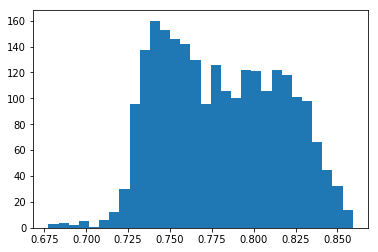

In [16]:
rgs=md.compute_rg(tr)
plt.hist(rgs,30)
plt.show()

### Next step

Continue with [Isomap projection of the landmarks](isomap.ipynb)